## In this notebook the FNet optimization results are validating against train and heldout data

In [1]:
import random
import pathlib
import sys
import yaml
from collections import defaultdict

import pandas as pd
import torch
from torch.utils.data import DataLoader
import mlflow
import mlflow.artifacts
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history
import joblib

## Read config

In [2]:
with open(pathlib.Path('.').absolute().parent.parent / "config.yml", "r") as file:
    config = yaml.safe_load(file)

## Import virtual_stain_flow software 

In [3]:
sys.path.append(config['paths']['software_path'])
print(str(pathlib.Path('.').absolute().parent.parent))

## Dataset
from virtual_stain_flow.datasets.PatchDataset import PatchDataset

## FNet training
from virtual_stain_flow.models.fnet import FNet

from virtual_stain_flow.transforms.MinMaxNormalize import MinMaxNormalize
from virtual_stain_flow.transforms.PixelDepthTransform import PixelDepthTransform

## Metrics
from virtual_stain_flow.metrics.PSNR import PSNR
from virtual_stain_flow.metrics.SSIM import SSIM

## Visualization software
from virtual_stain_flow.evaluation.visualization_utils import plot_predictions_grid_from_model
from virtual_stain_flow.evaluation.evaluation_utils import evaluate_per_image_metric
from virtual_stain_flow.evaluation.predict_utils import predict_image

/home/weishanli/Waylab/pediatric_cancer_atlas_analysis


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Define paths and other train parameters

In [4]:
## Loaddata for train and heldout set
LOADDATA_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
assert LOADDATA_FILE_PATH.exists(), f"File not found: {LOADDATA_FILE_PATH}"

LOADDATA_EVAL_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_heldout.csv'
assert LOADDATA_EVAL_FILE_PATH.exists(), f"Directory not found: {LOADDATA_EVAL_FILE_PATH}"

## Corresponding sc features directory containing cell coordiantes used for patch generation
SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])
assert SC_FEATURES_DIR.exists(), f"Directory not found: {SC_FEATURES_DIR}"

## Optimization Output Saved under these directories
MLFLOW_DIR = pathlib.Path('.').absolute() / 'optuna_mlflow'
assert MLFLOW_DIR.exists(), f"Mlflow directory not found: {MLFLOW_DIR}"

OPTUNA_JOBLIB_DIR = pathlib.Path('.').absolute() / 'optuna_joblib'
assert OPTUNA_JOBLIB_DIR.exists(), f"Optuna joblib directory not found: {OPTUNA_JOBLIB_DIR}"

## Validation Output Path
VALIDATION_OUTPUT_PATH = pathlib.Path('.').absolute() / 'Validation'
VALIDATION_OUTPUT_PATH.mkdir(exist_ok=True)

## Patch size definition
PATCH_SIZE = 256

## Channels for input and target are read from config
INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']

## Defines how the train data will be divided to train models on two levels of confluence

In [5]:
DATA_GROUPING = {
    'high_confluence': {
        'seeding_density': [12_000, 8_000]
    },
    'low_confluence': {
        'seeding_density': [4_000, 2_000, 1_000]
    }
}

In [6]:
mlflow.set_tracking_uri(MLFLOW_DIR / 'mlruns')

mlflow_results = {}
optuna_results = defaultdict(dict)

for confluence_group_name, _ in DATA_GROUPING.items():
    ## Access relevant optimization result and logs by confluence
    experiment_name = f'FNet_optimize_{confluence_group_name}'
    experiment = mlflow.get_experiment_by_name(experiment_name)
    mlflow_results[confluence_group_name] = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    for channel_name in TARGET_CHANNEL_NAMES:
        optuna_study_path = OPTUNA_JOBLIB_DIR / f"FNet_optimize_{channel_name}_{confluence_group_name}.joblib"
        study = joblib.load(optuna_study_path)
        optuna_results[confluence_group_name][channel_name] = study

        print(f"Optuna study {channel_name} {confluence_group_name}:")
        plot_param_importances(study).show()
        plot_optimization_history(study).show()

Optuna study OrigDNA high_confluence:


Optuna study OrigER high_confluence:


Optuna study OrigAGP high_confluence:


Optuna study OrigMito high_confluence:


Optuna study OrigRNA high_confluence:


Optuna study OrigDNA low_confluence:


Optuna study OrigER low_confluence:


Optuna study OrigAGP low_confluence:


Optuna study OrigMito low_confluence:


Optuna study OrigRNA low_confluence:


## Validate/Evaluate optimization trials against train and heldout dataset

In [8]:
EVAL_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_METRICS = [PSNR(_metric_name='psnr'), SSIM(_metric_name='ssim')]

## All validation results will be concatenated into this dataframe for convenience of comparison
all_metrics_df = pd.DataFrame()

## Iterate over train and heldout
for datasplit, loaddata_df in zip(
    ['train', 'heldout'], 
    [pd.read_csv(LOADDATA_FILE_PATH), pd.read_csv(LOADDATA_EVAL_FILE_PATH)]):

    DATASPLIT_VALIDATION_PATH = VALIDATION_OUTPUT_PATH / datasplit
    DATASPLIT_VALIDATION_PATH.mkdir(exist_ok=True)

    ## Iterate over confluence groups
    for confluence_group_name, conditions in DATA_GROUPING.items():

        CONFLUENCE_VALIDATION_PATH = DATASPLIT_VALIDATION_PATH / confluence_group_name
        CONFLUENCE_VALIDATION_PATH.mkdir(exist_ok=True)

        ## Subset loaddata to confluence  group
        loaddata_condition_df = loaddata_df.copy()
        for condition, values in conditions.items():
            loaddata_condition_df = loaddata_condition_df[
                loaddata_condition_df[condition].isin(values)
            ]

        ## Collect corresponding sc features
        sc_features = pd.DataFrame()
        for plate in loaddata_condition_df['Metadata_Plate'].unique():
            sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
            if not sc_features_parquet.exists():
                print(f'{sc_features_parquet} does not exist, skipping...')
                continue 
            else:
                sc_features = pd.concat([
                    sc_features, 
                    pd.read_parquet(
                        sc_features_parquet,
                        columns=['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
                    )
                ])

        ## Load data
        pds = PatchDataset(
            _loaddata_csv=loaddata_condition_df,
            _sc_feature=sc_features,
            _input_channel_keys=INPUT_CHANNEL_NAMES,
            _target_channel_keys=TARGET_CHANNEL_NAMES,
            _input_transform=PixelDepthTransform(src_bit_depth=16, target_bit_depth=8, _always_apply=True),
            _target_transform=MinMaxNormalize(_normalization_factor=(2 ** 16) - 1, _always_apply=True),
            patch_size=PATCH_SIZE,
            verbose=False,
            patch_generation_method="random_cell",
            n_expected_patches_per_img=50,
            patch_generation_random_seed=42
        )
        n_patches = len(pds)
        random.seed(42)
        visualization_patch_indices = random.sample(range(n_patches), 5)


        ## Group evaluation by channel (mostly unecessary)
        for target_channel_name, df in mlflow_results[confluence_group_name].groupby('params.channel_name'):
            
            CHANNEL_VALIDATION_PATH = CONFLUENCE_VALIDATION_PATH / target_channel_name
            CHANNEL_VALIDATION_PATH.mkdir(exist_ok=True)
            
            EXAMPLE_PATCH_PLOT_PATH = CHANNEL_VALIDATION_PATH / f'example_patch_plots'
            EXAMPLE_PATCH_PLOT_PATH.mkdir(exist_ok=True)
            
            pds.set_input_channel_keys(INPUT_CHANNEL_NAMES)
            pds.set_target_channel_keys([target_channel_name])
            # _, targets = next(iter(DataLoader(pds, batch_size=len(pds))))
            
            ## Iterate over models
            for _, row in df.iterrows():
                model_run_id = row['run_id']

                METRICS_FILE_PATH = CHANNEL_VALIDATION_PATH / f'{model_run_id}_metrics.csv'
                if METRICS_FILE_PATH.exists():
                    metrics_df = pd.read_csv(METRICS_FILE_PATH)
                    all_metrics_df = pd.concat([all_metrics_df, metrics_df])
                    continue

                model_uri = row['artifact_uri']
                model_weight_path = pathlib.Path(mlflow.artifacts.download_artifacts(artifact_uri=model_uri)) /\
                    'models' / 'best_model_weights.pth'
                if not model_weight_path.exists():
                    # in case there are uncompleted runs
                    print(f"Model weight not found for run {model_run_id}, skipping ...")
                    continue
                model_depth = int(row['params.depth'])
                model_channel_name = row['params.channel_name']

                model = FNet(depth=model_depth)
                try:
                    model.load_state_dict(torch.load(model_weight_path, weights_only=True))
                except:
                    print(f"Fail to load model weight for run {model_run_id}, skipping ...")
                    continue
                model.to(EVAL_DEVICE)
                
                targets, predictions = predict_image(
                    dataset = pds,
                    model = model,
                    device = EVAL_DEVICE
                )

                metrics_df = evaluate_per_image_metric(
                    predictions=predictions,
                    targets=targets,
                    metrics=EVAL_METRICS
                )
                metrics_mean = metrics_df.mean()

                ## Append optimization parameters to metrics
                metrics_df['datasplit'] = datasplit
                metrics_df['confluence'] = confluence_group_name
                params_values = {key: value for key, value in row.items() if key.startswith('params.')}
                for param, value in params_values.items():
                    metrics_df[param] = value
                metrics_df.to_csv(METRICS_FILE_PATH)

                # Append to all metrics
                all_metrics_df = pd.concat([all_metrics_df, metrics_df])
                
                # Produce string representation of metrics
                metrics_mean_str = '_'.join([f"{key}={value:.2f}" for key, value in metrics_mean.items()])
                # Produce strings to identify visualization for particular model
                params_str = '_'.join([f"{key.replace('params.','')}={value}" for key, value in params_values.items()])
                
                plot_predictions_grid_from_model(
                    model=model,
                    dataset=pds,
                    indices=visualization_patch_indices,
                    metrics=EVAL_METRICS,
                    device=EVAL_DEVICE,
                    # by making the plot name start with the metrics, the files can be ordered by metrics for easy comparison
                    save_path=CHANNEL_VALIDATION_PATH / f'{metrics_mean_str}_{params_str}.png'
                )
                # plot_patches(
                #     dataset=pds,
                #     n_patches=5,
                #     model=model,
                #     random_seed=42,
                #     device=EVAL_DEVICE,
                #     metrics=EVAL_METRICS,
                #     show_plot=False,
                #     save_path=EXAMPLE_PATCH_PLOT_PATH / f'{metrics_mean_str}_{params_str}.png'
                # )

Model weight not found for run 8612de5e932b4eb3aa40d7cd9f5bf4dd, skipping ...
Model weight not found for run 8612de5e932b4eb3aa40d7cd9f5bf4dd, skipping ...


In [9]:
all_metrics_df.to_csv(VALIDATION_OUTPUT_PATH / 'all_validation_metrics.csv')

/tmp/ipykernel_2802328/2565388459.py:38: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_2802328/2565388459.py:38: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_2802328/2565388459.py:38: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_2802328/2565388459.py:38: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavi

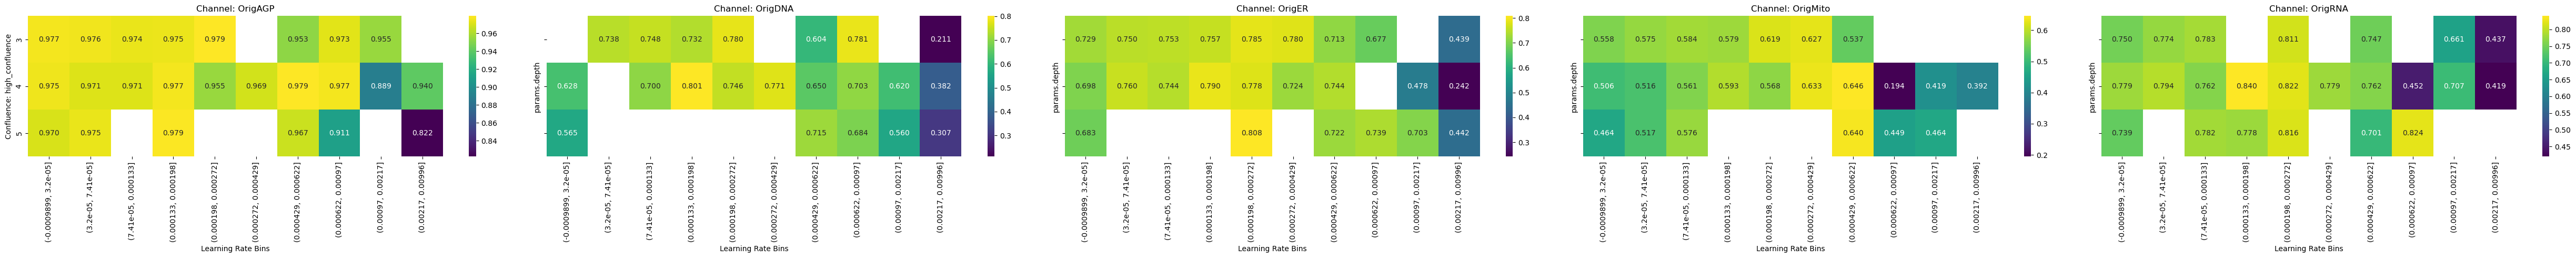

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select only 'train' datasplit
train_df = all_metrics_df[all_metrics_df["datasplit"] == "train"].copy()
train_df["params.lr"] = pd.to_numeric(train_df["params.lr"], errors="coerce")
train_df = train_df.dropna(subset=["params.lr"])

# Define binning for params.lr only
train_df["lr_bin"] = pd.qcut(train_df["params.lr"], q=10, duplicates="drop")

# Get unique values for subplot arrangement
channel_names = train_df["params.channel_name"].unique()
confluence_levels = train_df["confluence"].unique()

# Determine subplot grid size
cols = len(channel_names)  # One column per channel_name
rows = len(confluence_levels)  # One row per confluence

fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 5 * rows), sharex=True, sharey=True)

# Ensure axes is a 2D array for consistent indexing
if rows == 1:
    axes = np.array([axes])  # Convert to 2D array with one row
if cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array with one column

# Iterate through unique combinations of (channel_name, confluence) and plot heatmap
for i, confluence in enumerate(confluence_levels):
    for j, channel in enumerate(channel_names):
        ax = axes[i, j]

        # Filter data for this combination
        subset = train_df[(train_df["params.channel_name"] == channel) & (train_df["confluence"] == confluence)]

        # Create pivot table with integer depth values
        pivot_table = subset.pivot_table(index="params.depth", columns="lr_bin", values="SSIM", aggfunc="mean")

        # Plot heatmap
        sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".3f", ax=ax)

        # Titles and labels
        if i == 0:
            ax.set_title(f"Channel: {channel}")
        if j == 0:
            ax.set_ylabel(f"Confluence: {confluence}")
        ax.set_xlabel("Learning Rate Bins")

plt.tight_layout()
plt.show()
